In [1]:
from qiskit import *
from qiskit.visualization import plot_bloch_multivector, plot_bloch_vector, plot_histogram
from qiskit.compiler import transpile, assemble

from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq import least_busy

import matplotlib 
import numpy as np
import math
from fractions import Fraction
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#basic testing gate from qiskit textbook

def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

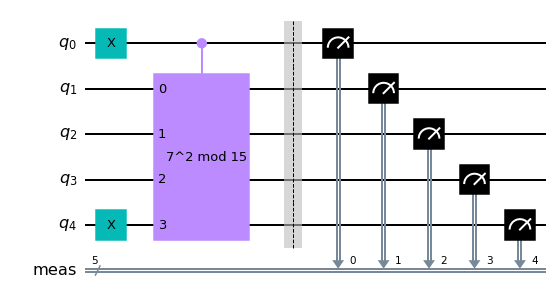

In [3]:
qc = QuantumCircuit(5)
a = 7
power = 2
qc.x(0)
qc.x(4)
qc.append(c_amod15(a, power), range(5))
qc.measure_all()
qc.draw('mpl')

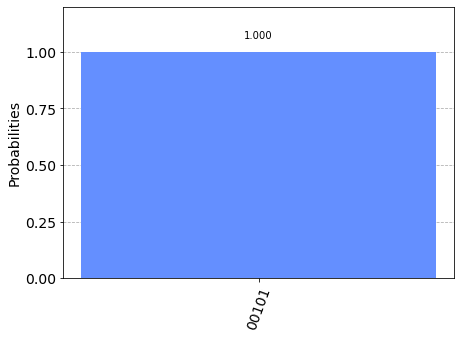

In [4]:
backend_sim = Aer.get_backend('qasm_simulator')
job_sim = execute(qc, backend_sim, shots = 1024)
result_sim = job_sim.result()
counts = result_sim.get_counts(qc)
plot_histogram(counts)

In [5]:
def inv_qft(n):
    qc = QuantumCircuit(n)
    for qubit in range (n//2):
        qc.swap(qubit, n-qubit-1)
        
    for j in range(n):
        for m in range(j):
            qc.cp(-pi/(2*(j-m)), m, j)
        qc.h(j)
    
    return qc

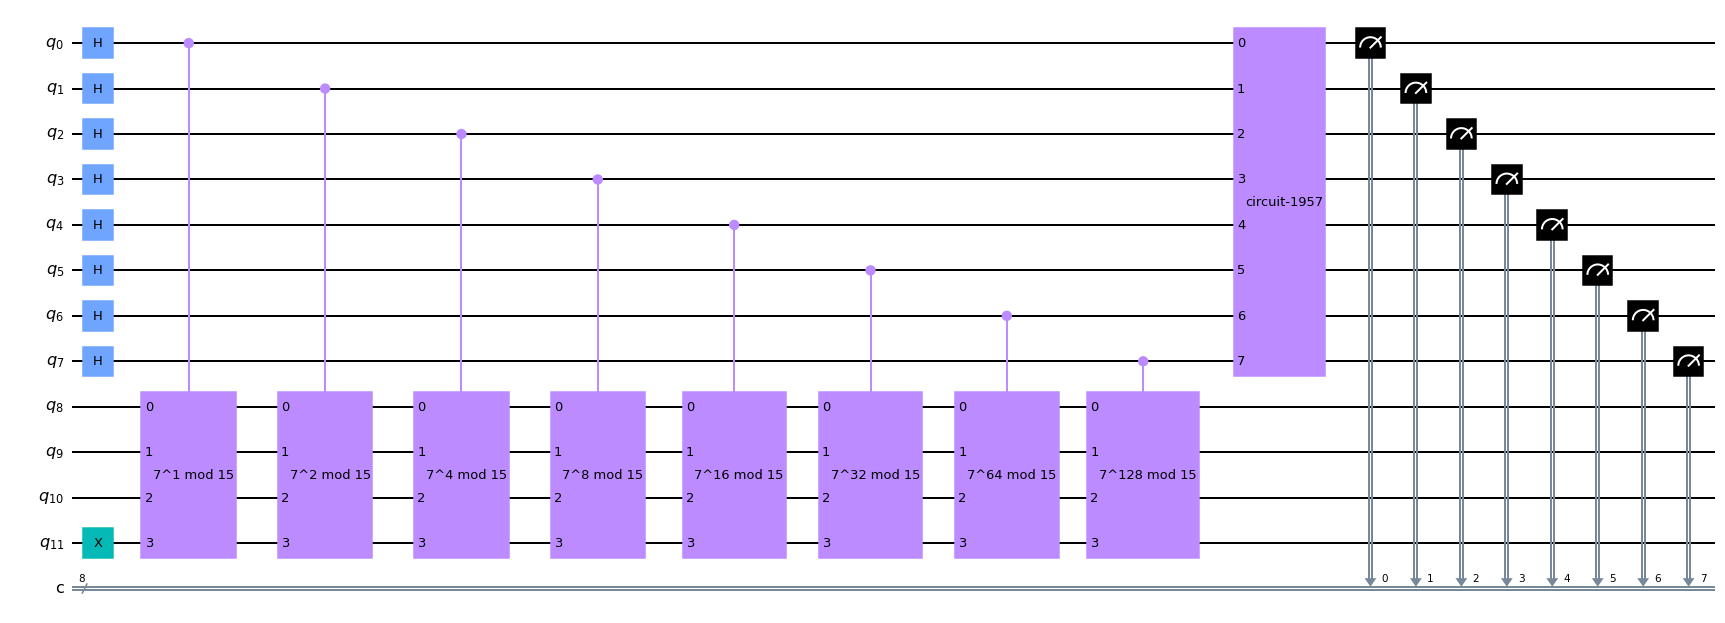

In [6]:
n = 8
a = 7
qc = QuantumCircuit(n + 4, n)
qc.h(range(n))

qc.x(n +3)
for q in range(n):
    qc.append(c_amod15(a, 2**q), [q] + [i + n for i in range(4)])

qc.append(inv_qft(n), range(n))
qc.measure(range(n), range(n))
qc.draw('mpl', fold = -1)

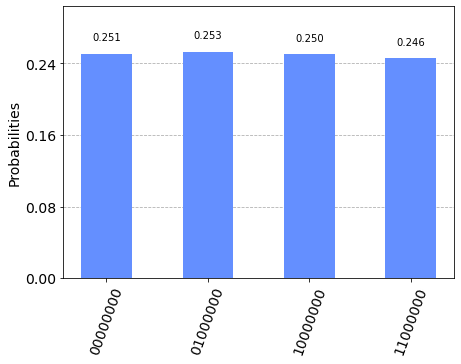

In [7]:
backend_sim = Aer.get_backend('qasm_simulator')
job_sim = execute(qc, backend_sim, shots = 1024)
result_sim = job_sim.result()
counts = result_sim.get_counts(qc)
plot_histogram(counts)

In [8]:
phase_list = []
frac_list = []
r_list = []

for output in counts:
    decimal = int(output, 2)
    phase = decimal / 2**n
    phase_list.append(phase)
    frac_list.append(Fraction(phase).limit_denominator(15))
    r_list.append(Fraction(phase).denominator)
                  
for i in range(len(counts)):
    print(phase_list[i], frac_list[i], r_list[i])

0.75 3/4 4
0.0 0 1
0.5 1/2 2
0.25 1/4 4


In [9]:
#Classical postprocessing tbd